In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

In [2]:
class DynSys:
    def __init__(self, param):
        self.param = param
        N_DATA, N_NODE, ALPHA = param['N_DATA'], param['N_NODE'], param['ALPHA']
        T, STD = param['T'], param['STD']

        ################################
        # Create Interaction matrix
        ################################
        self.M = np.zeros((N_NODE, N_NODE))
        for i in range(N_NODE):
            self.M[i, i] = ALPHA

        for i in range(N_NODE-1):
            self.M[i + 1, i] = 1 - ALPHA

        ################################
        # Create data
        ################################
        self.data = np.zeros((N_NODE, N_DATA))
        for i in range(1, N_DATA):
            self.data[:, i] = self.M.dot(self.data[:, i-1])        # Propagate signal
            self.data[0, i] += np.sin(2 * np.pi * i / T)           # Input to the first node
            self.data[:, i] += np.random.normal(0, STD, N_NODE)    # Noise to all nodes
           
        
    def computeTE(self, min_lag, max_lag):
        # a) Convert data to ITDxl format
        dataIDTxl = Data(self.data, dim_order='ps')

        # b) Initialise analysis object and define settings
        network_analysis = MultivariateTE()
        settings = {'cmi_estimator': 'JidtGaussianCMI',
                    'max_lag_sources': max_lag,
                    'min_lag_sources': min_lag}

        # c) Run analysis
        return network_analysis.analyse_network(settings=settings, data=dataIDTxl)

            
    def plot(self):    
        fig, ax = plt.subplots(ncols=2, figsize=(15,5))
        ax[0].imshow(self.M)
        ax[0].set_title("Connectivity-matrix")
        for j in range(self.param['N_NODE']):
            ax[1].plot(self.data[j], label=str(j))
        ax[1].legend()
        ax[1].set_title("Dynamics")
        plt.show()
        
def parseResults(results, N_NODE):
    out = {'src' : [], 'trg' : [], 'lag' : [], 'te' : [], 'p' : []}
    
    # Print details of TE estimation
    for i in range(N_NODE):
        rezThis = results.get_single_target(i, fdr=False)
        
        out['src'] += [val[0] for val in rezThis['selected_vars_sources']]
        out['lag'] += [val[1] for val in rezThis['selected_vars_sources']]
        out['te']  += list(rezThis['selected_sources_te'])
        out['p']   += list(rezThis['selected_sources_pval'])
        out['trg'] += [i] * len(rezThis['selected_sources_pval'])
    
    df = pd.DataFrame.from_dict(out)
    df = df.sort_values(by=['src', 'trg'])
    
    return df
    

In [3]:
%%time

# Set parameters
param = {
    'ALPHA'   : 0.9,
    'N_NODE'  : 12,
    'N_DATA'  : 10000,
    'T'       : 100,
    'STD'     : 0.2
}
min_lag, max_lag = 1, 5

# Create dynamical system and compute TE
DS1 = DynSys(param)
results = DS1.computeTE(min_lag, max_lag)

Adding data with properties: 5 processes, 10000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (2, 1) maximum statistic, n_perm: 200
 -- not significant

--

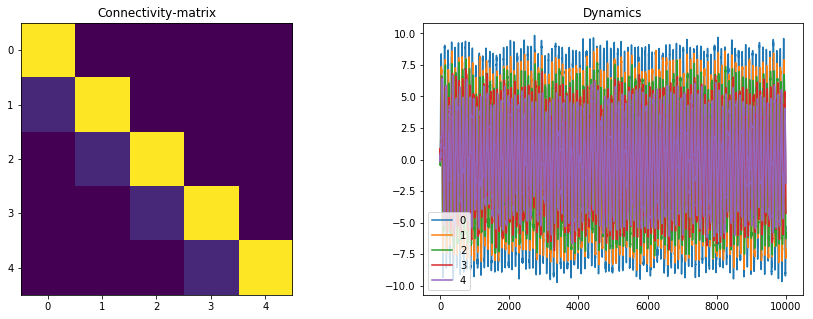

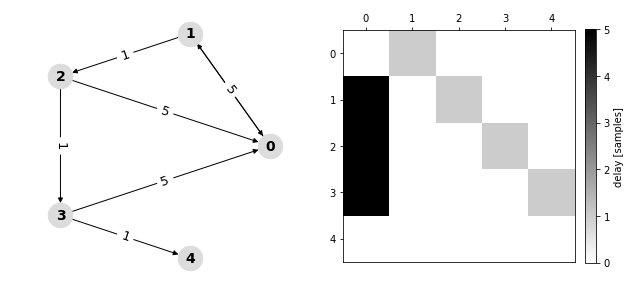

In [4]:
# Plot dynamical system
DS1.plot()

# Plot inferred network to console and via matplotlib
#results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=results, weights='max_te_lag', fdr=False)
plt.show()

# Print details of TE estimation
parsedRes = parseResults(results, param['N_NODE'])

### 2. STATISTICAL SANITY CHECK

**TODO:**
1. Construct sets: `[lags], [N_NODE], [noise variances], [period lengths]`
2. Subselect reasonable combinations
3. Run code for each
4. For each run, save: `MAT_TE, MAT_DELAY`
5. Compute:
  * Frequency number correct connection = N as function of N
  * Frequency all correct delays are correct
  * Frequency exists fake connect
  * Ratio MAX_FAKE_TE / AVG_REAL_TE, MAX_FAKE_TE / MIN_REAL_TE
  * Number of fake, number of fake within 10% of MAX_FAKE_TE
  * Effect of noise for fixed everything else, max_lag=1 and max_lag=6
  * Effect of period for fixed everything else, max_lag=1 and max_lag=6

In [5]:
%%time
# Set parameters
param = {
    'ALPHA'   : 0.9,
    'N_NODE'  : 12,
    'N_DATA'  : 10000,
    'T'       : 100,
    'STD'     : 0.2
}
min_lag, max_lag = 1, 5

N_PARAM = 40
nDataLst = (10**(np.linspace(2, 5, N_PARAM))).astype(int)
resultsLst = []

for N_DATA in nDataLst:
    param['N_DATA'] = N_DATA
    
    DS1 = DynSys(param)
    resultsLst += [parseResults(DS1.computeTE(min_lag, max_lag), param['N_NODE'])]

Adding data with properties: 5 processes, 100 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------

testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 2)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4]

Target: 2 - testing sources [0, 1, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 

testing candidate: (1, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 3), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 3)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 

testing candidate: (1, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (1, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 5)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Target: 1 - testing sources [0, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (1, 3) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 3)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 3)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4]

Target: 3 - testing sources [0, 1, 2, 4]

---------------------------- (1)


Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (4, 3), (3, 1)]
omnibus test, n_

testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (1, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 5)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Target: 1 - testing sources [0, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 

testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4]

Target: 3 - testing sources [0, 1, 2, 4]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2)

 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (3, 2), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5), (3, 2)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5

testing candidate: (2, 2) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic, n_perm: 200
testing candidate: (3, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 2), (1, 3)]
testing candidate: (1, 3) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (2, 2), (1, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 2), (1, 3)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Target: 1 - testing sources [0, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum 

testing candidate: (2, 2) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (1, 2) maximum statistic, n_perm: 200
testing candidate: (1, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (2, 2), (1, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 2)]
final target samples: [(2, 1), (2, 5), (2, 2)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4]

Target: 3 - testing sources [0, 1, 2, 4]

----------------

testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 

testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (2, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 5)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Target: 1 - test

testing candidate: (0, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4]

Target: 2 - testing sources [0, 1, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 

testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2)

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]


Adding data with properties: 5 processes, 3455 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significan

testing candidate: (1, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5), (1, 5), (3, 5)]
testing candidate: (3, 5) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (2, 5), (1, 5), (3, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 5), (1, 5), (3, 5)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Target: 1 - testing sources [0, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include sourc

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4]

Target: 3 - testing sources [0, 1, 2, 4]

---------------------------- (1)

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0,

Adding data with properties: 5 processes, 8376 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (4, 1) maximum statistic, n_perm: 200
 -- not significant

---

testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4]

Target: 2 - testing sources [0, 1, 3, 4]

---------------------------- (1)

testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (4, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4]

Target: 3 - testing sources [0, 1, 2, 4]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0,

final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final 

testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5), (3, 5), (1, 5), (4, 5)]
testing candidate: (4, 5) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0,

testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (4, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4]

Target: 2 - test

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4]

Target: 3 - testing sources [0, 1, 2, 4]

---------------------------- (1)

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (1, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) incl

testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]


Adding data with properties: 5 processes, 49238 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significa

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (2, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5), (3, 5), (1, 5), (4, 5)]
testing candidate: (4, 5) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (0, 3), (2, 5), (3, 5), (1, 5), (4, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 5), (3, 5), (1, 5), (4, 5)]
final target samples: [(0, 1), (0, 5), (0, 3)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Target: 1 - testing sources [0, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1,

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4]

Target: 2 - testing sources [0, 1, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 1) 
maxi

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (2, 2), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5), (2, 2)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4]

Target: 3 - testing sources [0, 1, 2, 4]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candida

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (1, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maxi

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


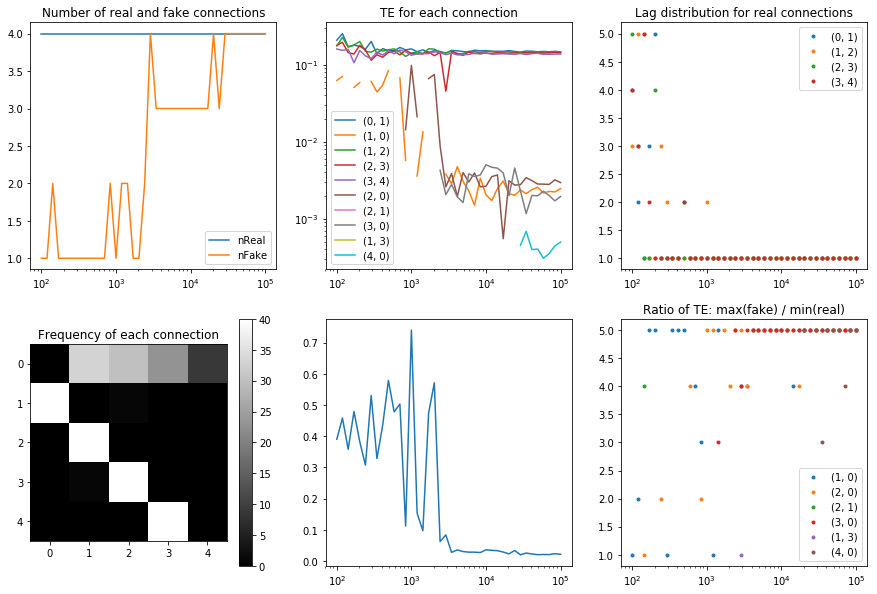

In [52]:
# Create keys for found connections
key2idx = {}
for rez in resultsLst:
    for index, row in rez.iterrows():
        key = (int(row['src']), int(row['trg']))
        if key not in key2idx:
            key2idx[key] = len(key2idx)

N_CONN_FOUND = len(key2idx)
isReal = np.array([DS1.M[j,i] != 0 for i,j in key2idx.keys()])
statsTE = np.zeros((N_CONN_FOUND, N_PARAM)) + np.nan
statsLag = np.zeros((N_CONN_FOUND, N_PARAM)) + np.nan

# Fill in computed TE and lags for found connections
for iParam, rez in enumerate(resultsLst):
    for index, row in rez.iterrows():
        key = (int(row['src']), int(row['trg']))
        idx = key2idx[key]

        # Fill in this data point
        statsTE[idx][iParam] = row['te']
        statsLag[idx][iParam] = row['lag']
    
######################
# Analysis
######################

nReal = np.zeros(N_PARAM)  # Number of real connections found
nFake = np.zeros(N_PARAM)  # Number of fake connections found
M_AVG = np.zeros((param['N_NODE'], param['N_NODE']))  # Frequency of each connection

maxFakeMinReal = np.divide(
    np.nanmax(statsTE[np.logical_not(isReal)], axis=0),
    np.nanmin(statsTE[isReal], axis = 0))

for key, idx in key2idx.items():
    connExist = np.logical_not(np.isnan(statsTE[idx]))  # When does this connection exist
    
    if isReal[idx]:
        nReal += connExist
    else:
        nFake += connExist
    
    M_AVG[key[1], key[0]] = np.sum(connExist)# / N_PARAM

######################
# Plot Analysis results
######################

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
ax[0][0].semilogx(nDataLst, nReal, label='nReal')
ax[0][0].semilogx(nDataLst, nFake, label='nFake')
ax[0][0].legend()
ax[0][0].set_title('Number of real and fake connections')

im = ax[1][0].imshow(M_AVG, cmap='gray')
ax[1][0].set_title('Frequency of each connection')
fig.colorbar(im, ax=ax[1][0])

for key, idx in key2idx.items():
    ax[0][1].loglog(nDataLst, statsTE[idx], '-', label=str(key))
ax[0][1].legend()
ax[0][1].set_title('TE for each connection')

for key, idx in key2idx.items():
    if isReal[idx]:
        ax[0][2].semilogx(nDataLst, statsLag[idx], '.', label=str(key))
    else:
        ax[1][2].semilogx(nDataLst, statsLag[idx], '.', label=str(key))
ax[0][2].legend()
ax[1][2].legend()
ax[0][2].set_title('Lag distribution for real connections')
ax[1][2].set_title('Lag distribution for fake connections')

ax[1][1].semilogx(nDataLst, maxFakeMinReal)
ax[1][2].set_title('Ratio of TE: max(fake) / min(real)')

plt.show()